<a href="https://colab.research.google.com/github/FabriceBeaumont/MachineLearning/blob/main/pytorch/PyTorchWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sources:**
- ['56 - ResNet Paper Implementation From Scratch with PyTorch'](https://www.youtube.com/watch?v=P8U1VL93jzA&t=1298s) by Rohan-Paul-AI, YouTube Tutorial ([Code](https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Computer_Vision/56-ResNet56_From_Scratch_PyTorch.ipynb))


# SetUp

## Imports

In [2]:
# Standard imports.
from typing import List, Set, Dict, Tuple, Any, Callable, Union
from collections import OrderedDict
import os
import shutil
import numpy as np
import pandas as pd

In [ ]:
# For evaluation
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

In [1]:
# Imports for ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

!nvidia-smi

Thu Dec  7 08:13:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## General settings and parameters

In [ ]:
# Define the column names for saving data in a DataFrame
COL_EPOCHS: str = 'Epochs'
COL_TRAIN_LOSS: str = 'Training loss'
COL_VAL_LOSS: str = 'Validation loss'

COL_TRAIN_LOSS_DIFF: str = 'Training loss diff'
COL_VAL_LOSS_DIFF: str = 'Validation loss diff'

In [ ]:
# Define filenames
FILEPATH_CKPTS: str = "/content/resnet-56_ckpt_{}"
FILEPATH_MODEL: str = "/content/resnet-56_model_e{}"
FILEPATH_PLOT: str = "/content/resnet-50_losses" # os.path.join("plots", f"{file_id}_mean_loss_w{window_size}_r{plot_resolution}.jpg")

# ResNet definition from scratch

## Define the model

Implementation based on the original paper from implementing ResNet on the CIFAR-10 Dataset.

Input: $32\times 32$ images (per-pixel mean subtracted).
First layer: $3\imtes 3# convolutions

Stack of $6n$ layers with $3\times 3$ convolutions on the feature maps of sizes $\{32, 16, 8\}$ respectively, with $2n$ layers for each feature map size.

Numbers of filters: $\{16, 32, 64\}$ respectively.

Subsampling: Convolutions with a stride of $2$

End: Global average pooling, a $10$-way fully-connected layer, and softmax function.

Number of stacked weighted layers: $6n+2$

| output map size | 32 x 32 | 16 x 16 | 8 x 8 |
|-----------------|---------|---------|-------|
| #layers         | 1+2n    | 2n      | 2n    |
| #filters        | 16      | 32      | 64    |

Experiments: For $n = \{3, 5, 7, 9\}$ (20, 32, 44, and 56-layer networks).

When shortcut connections are used, they are connected to the pairs of $3 \times 3$ layers (totally $3n$ shortcuts).

In [ ]:
class LambdaLayer(nn.Module):
    """ A Lambda Layer allows to perform arbitrary operations specified by the "lambd" argument (lambda functions).

    Attributes:
        lambd: a function that defines the operation to be performed on the input.
    """

    def __init__(self, lambd: Callable):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lambd(x)

In [ ]:
class BasicConvBlock(nn.Module):
    ''' Takes an input with 'in_channels', applies some blocks of convolutional layers
    to reduce it to out_channels and adds it up to the original input.
    If their sizes mismatch, then the output defaults to the identity function on the input.

    This will implement the regular basic Conv Block and the shortcut block
    that does the dimension matching job when dimension changes between 2 blocks, with stride 2:
        - A) Use identity shortcuts with zero padding to increase channel dimension.
        - B) Use 1x1 convolution to increase channel dimension (projection shortcut).
    '''

    def __init__(self, in_channels: int, out_channels: int, stride:int=1, option:str='A'):
        super(BasicConvBlock, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)),
            ('bn1',   nn.BatchNorm2d(out_channels)),
            ('act1',  nn.ReLU()),
            ('conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)),
            ('bn2',   nn.BatchNorm2d(out_channels))
        ]))

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            if option == 'A':
                # Use identity shortcuts with zero padding to increase channel dimension.
                pad_to_add = out_channels // 4

                # Using stride 2, apply the padding to (width, height, center, norm)
                # and [width_beginning, width_end, height_beginning, height_end, channel_beginning, channel_end, batchLength_beginning, batchLength_end ]
                self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], (0,0, 0,0, pad_to_add, pad_to_add, 0,0)))
            if option == 'B':
                self.shortcut = nn.Sequential(OrderedDict([
                    ('s_conv1', nn.Conv2d(in_channels, 2*out_channels, kernel_size=1, stride=stride, padding=0, bias=False)),
                    ('s_bn1', nn.BatchNorm2d(2*out_channels))
                ]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        # Add the outputs of the shortcut layer
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [ ]:
class ResNet(nn.Module):
    """ ResNet-56 architecture for CIFAR-10 Dataset of shape 32*32*3.

    Args:
        block_type (nn.Module): The type of residual block to use.
        num_blocks (List[int]): List containing the number of blocks for each layer.

    Attributes:
        in_channels (int): Number of input channels.
        conv0 (nn.Conv2d): Initial convolutional layer.
        bn0 (nn.BatchNorm2d): Batch normalization layer.
        block1 (nn.Sequential): First block layer.
        block2 (nn.Sequential): Second block layer.
        block3 (nn.Sequential): Third block layer.
        avgpool (nn.AdaptiveAvgPool2d): Adaptive average pooling layer.
        linear (nn.Linear): Linear layer for classification.
    """

    def __init__(self, block_type: nn.Sequential, num_blocks: List[int]):
        super(ResNet, self).__init__()

        self.in_channels: int = 16

        self.conv0: nn.Conv2d = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0: nn.BatchNorm2d = nn.BatchNorm2d(16)

        self.block1: nn.Sequential = self.__build_layer(block_type, 16, num_blocks[0], starting_stride=1)

        self.block2: nn.Sequential = self.__build_layer(block_type, 32, num_blocks[1], starting_stride=2)

        self.block3: nn.Sequential = self.__build_layer(block_type, 64, num_blocks[2], starting_stride=2)

        self.avgpool: nn.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((1,1))
        self.linear: nn.Linear = nn.Linear(64, 10)

    def __build_layer(self, block_type: nn.Module, out_channels: int, num_blocks: int, starting_stride: int) -> nn.Sequential:
        """ Build a layer consisting of multiple residual blocks. """

        strides_list_for_current_block: List[int] = [starting_stride] + [1]*(num_blocks-1)

        layers: List[nn.Module] = []
        for stride in strides_list_for_current_block:
            layers.append(block_type(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn0(self.conv0(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

## Assemble the model

In [ ]:
def ResNet56():
    return ResNet(block_type=BasicConvBlock, num_blocks=[9,9,9])

In [ ]:
model = ResNet56()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
              ReLU-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
    BasicConvBlock-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,304
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
   BasicConvBlock-14           [-1, 16,

## Dataset loaders
Here we will use the CIFAR-10 Dataset

In [ ]:
def get_dataloaders_cifar() -> List[torch.utils.data.DataLoader]:
    """ Create dataloaders for the CIFAR-10 dataset.

    Returns:
        train_loader (torch.utils.data.DataLoader): Dataloader for the training set.
        val_loader   (torch.utils.data.DataLoader): Dataloader for the validation set.
        test_loader  (torch.utils.data.DataLoader): Dataloader for the test set.
    """
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])

    # Input Data in Google Drive
    train_dataset = datasets.CIFAR10('/content/CIFAR10', train=True,  download=True, transform=transform)
    test_dataset  = datasets.CIFAR10('/content/CIFAR10', train=False, download=True, transform=transform)

    # Split the training dataset into the actual training set (45000) and a validation set (5000).
    train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))

    print(f"Image shape of a random sample image: {train_dataset[0][0].numpy().shape}\n\n")

    print(f"Training Set:  \t{len(train_dataset)}\t images")
    print(f"Validation Set:\t{len(val_dataset)}\t images")
    print(f"Test Set:      \t{len(test_dataset)}\t images")

    BATCH_SIZE = 32

    # Generate dataloader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=10000,      shuffle=True)

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_dataloaders_cifar()

Files already downloaded and verified
Files already downloaded and verified
Image shape of a random sample image: (3, 32, 32)


Training Set:  	45000	 images
Validation Set:	5000	 images
Test Set:      	10000	 images


## Training

In [ ]:
def train_model(
        loss_fct: Callable = nn.CrossEntropyLoss(),
        optimizer = optim.Adam(model.parameters(), lr=0.01),
        nr_epochs: int = 15,
        nr_ckpts:  int = 10,
        ckpts_filename: str = "/content/ckpt_e{}",
        model_filename: str = "/content/model_e{}"
    ) -> pd.DataFrame:
    avg_epoch_losses_train: List[float] = []
    avg_epoch_losses_val: List[float] = []
    # Compute a divisor that can be used
    # to evaluate an if-statement to True 'nr_ckpts' times when iterating over 'nr_epochs' samples
    trigger_epoch_divisor: int = nr_epochs // nr_ckpts

    nr_train_samples: int = len(train_loader.dataset)
    nr_val_samples: int   = len(val_loader.dataset)

    # Start the training in epochs
    for epoch in range(nr_epochs):
        batch_loss_train: float = .0
        correct_predictions_train: float = .0

        # Set the model to evaluation mode and run the training on the GPU
        model.train().cuda()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # For every Mini-batch during the training phase, explicitly set the gradients
            # to zero before the backpropragation
            optimizer.zero_grad()

            # Start the forward pass
            prediction = model(inputs)

            # Calculate the loss
            loss = loss_fct(prediction, labels)

            # Do backpropagation
            loss.backward()
            # Update weights
            optimizer.step()

            # Find the highest probability for all predictions (for all samples = axis 1)
            _, predicted_outputs = torch.max(prediction.data, 1)
            correct_predictions_train += (predicted_outputs == labels).float().sum().item()

            # Compute the batch loss
            # There fore multiply each average batch loss with batch-length
            batch_loss_train += loss.data.item() * inputs.shape[0]


        # Calculate the average epoch loss on the training set and save it
        epoch_loss_train = batch_loss_train / nr_train_samples
        avg_epoch_losses_train.append(epoch_loss_train)

        # Compute the prediction accuracy on the training set
        train_acc: float = correct_predictions_train / nr_train_samples

        # Now check trained weights on the validation set
        batch_loss_val: float = .0
        correct_predictions_val: float = .0

        # Set the model to evaluation mode
        model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                prediction = model(inputs)

                # Compute the loss
                loss = loss_fct(prediction, labels)

                # Compute validation accuracy
                _, predicted_outputs = torch.max(prediction.data, 1)
                correct_predictions_val += (predicted_outputs == labels).float().sum().item()

                # Compute batch loss
                batch_loss_val += (loss.data.item() * inputs.shape[0])


            # Calculate the average epoch loss on the validation set and save it
            epoch_loss_val = batch_loss_val / nr_val_samples
            avg_epoch_losses_val.append(epoch_loss_val)

            # Compute the prediction accuracy on the validation set
            val_acc: float = correct_predictions_val / nr_val_samples


        print(f"[Epoch {epoch + 1}/{nr_epochs}]:\ttrain-loss = {epoch_loss_train: 0.6f} | train-acc = {train_acc * 100:0.2f} % | val-loss = {epoch_loss_val:0.6f} | val-acc = {val_acc*100:0.2f} %")

        if epoch % (trigger_epoch_divisor) == 0:
            torch.save(model.state_dict(), ckpts_filename.format(epoch + 1))

    torch.save(model.state_dict(), model_filename.format(nr_epochs))

    df_losses = pd.DataFrame({COL_EPOCHS: range(nr_epochs), COL_TRAIN_LOSS: train_losses, COL_VAL_LOSS: val_losses})
    df_losses.set_index(COL_EPOCHS)
    return df_losses

In [ ]:
df_losses = train_model(
    loss_fct = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model.parameters(), lr=0.01),
    nr_epochs = 15,
    nr_ckpts = 10,
    ckpts_filename = FILEPATH_CKPTS,
    model_filename = FILEPATH_CKPTS,
)

[Epoch 1/15]:	train-loss =  0.051611 | train-acc = 98.23 % | val-loss = 0.997384 | val-acc = 82.20 %
[Epoch 2/15]:	train-loss =  0.052311 | train-acc = 98.25 % | val-loss = 0.948003 | val-acc = 82.74 %
[Epoch 3/15]:	train-loss =  0.040834 | train-acc = 98.60 % | val-loss = 0.971482 | val-acc = 83.26 %
[Epoch 4/15]:	train-loss =  0.041309 | train-acc = 98.59 % | val-loss = 0.994605 | val-acc = 82.08 %
[Epoch 5/15]:	train-loss =  0.047809 | train-acc = 98.42 % | val-loss = 0.948303 | val-acc = 82.54 %
[Epoch 6/15]:	train-loss =  0.039557 | train-acc = 98.63 % | val-loss = 0.948112 | val-acc = 83.26 %
[Epoch 7/15]:	train-loss =  0.035006 | train-acc = 98.83 % | val-loss = 0.950352 | val-acc = 83.18 %
[Epoch 8/15]:	train-loss =  0.042924 | train-acc = 98.54 % | val-loss = 1.015465 | val-acc = 82.90 %
[Epoch 9/15]:	train-loss =  0.039408 | train-acc = 98.68 % | val-loss = 1.134408 | val-acc = 81.18 %
[Epoch 10/15]:	train-loss =  0.037642 | train-acc = 98.73 % | val-loss = 0.935009 | val-acc

## Evaluation

### Evaluate the logged values

In [ ]:
derivatives = pd.DataFrame({COL_TRAIN_LOSS_DIFF: df_losses[COL_TRAIN_LOSS].diff(), COL_VAL_LOSS_DIFF: df_losses[COL_VAL_LOSS].diff()})
# The first value will be Nan, since there is no -1 value from which the 0th could be subtracted
# Set it to zero since this is the default derivative for non existing loss developments
derivatives.iloc[0, 0] = 0
derivatives.iloc[0, 1] = 0
# Normalize the difference to get the derivative. Notice that this inclued the resultion of the loss plot,
# and the resolution of the plot of the derivative approximation
df_losses.loc[:, COL_TRAIN_LOSS_DIFF] = derivatives[COL_TRAIN_LOSS_DIFF]
df_losses.loc[:, COL_VAL_LOSS_DIFF] = derivatives[COL_VAL_LOSS_DIFF]
df_losses.head()

,Epochs,Training loss,Validation loss,Training loss diff,Validation loss diff
0,0,1.090850,0.998076,0.000000,0.000000
1,1,0.815416,0.894619,-0.275434,-0.103457
2,2,0.647875,0.601666,-0.167541,-0.292954
3,3,0.538929,0.575062,-0.108946,-0.026603
4,4,0.461340,0.630038,-0.077589,0.054976
5,5,0.393736,0.576273,-0.067604,-0.053765
6,6,0.334835,0.590843,-0.058901,0.014569
7,7,0.282070,0.573705,-0.052765,-0.017137
8,8,0.237099,0.648952,-0.044971,0.075247
9,9,0.200134,0.675906,-0.036965,0.026954


In [ ]:
overfitting_epoch: int = None

# Get the first epoch, where the training loss is decreasing while the validation loss is increasing
overfitting_epochs = df_losses[(df_losses[COL_TRAIN_LOSS_DIFF] < 0) & (df_losses[COL_VAL_LOSS_DIFF] > 0)]
if len(overfitting_epochs) > 0:
    overfitting_epoch = int(overfitting_epochs.iloc[0].name) - 1

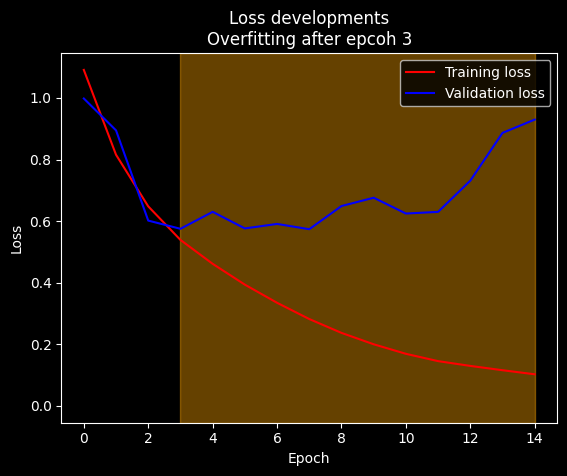

In [ ]:
# Plot the training and validation loss and where overfitting is assumed
fig_loss, ax = plt.subplots()

plt.plot(df_losses[COL_EPOCHS], df_losses[COL_TRAIN_LOSS], color='red', label='Training loss')
plt.plot(df_losses[COL_EPOCHS], df_losses[COL_VAL_LOSS], color='blue', label='Validation loss')

# If overfitting is assumed after a specified epoch, highlight these
overfitting_suptitle: str = ''
if overfitting_epoch is not None:
    ax.fill_between(df_losses[COL_EPOCHS], 0, 1, where = df_losses[COL_EPOCHS] >= overfitting_epoch,
                    color='orange', alpha=.01, transform=ax.get_xaxis_transform())
    overfitting_suptitle = f"\n(Assume overfitting after epoch {overfitting_epoch})"

plt.legend()
# Add title and axis labels
plt.title(f"Loss developments" + overfitting_suptitle)
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Save the figure
fig_loss.savefig(FILEPATH_PLOT)
plt.show()

### Evaluate the loaded model

In [ ]:
# Restore the model.
model = ResNet56()
model.load_state_dict(torch.load('/content/resnet-56_weights_gpu_e15'))

<All keys matched successfully>

In [ ]:
nr_test_samples: int = 10000
correct_predictions_val: float = .0

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        prediction = model(inputs)

        # Compute validation accuracy
        _, predicted_class = torch.max(prediction.data, 1)
        correct_predictions_val += (predicted_class == labels).float().sum().item()

test_accuracy: float = correct_predictions_val / nr_test_samples

print(f"Test accuracy on {nr_test_samples} samples: {test_accuracy * 100: 0.2f} %")

Test accuracy on 10000 samples:  80.38 %
